# Обучение линейного классификатора 

Для выполнения этого задания нужно будет дописать код в этом ноутбуке  

В этом упражнении Вам предстоит:

- реализовать функцию потерь **CrossEntropyLoss** с регуляризацией для батча произвольного размера
- реализовать векторизованную функцию для вычисления **аналитического градиента**
- **проверить свою реализацию** с градиентом, вычисленным методом конечных разностей
- **оптимизировать** веса линейного классификатора с помощью градиентного спуска **SGD**
- **найти лучшие learning rate и regularization** 
- **визуализировать** матрицу оптимальных весов.  

Детальный разбор вычисления градиента  
https://youtu.be/bZihskzsSjM


In [1]:
# Load data
%%bash
git clone https://github.com/balezz/modern_dl.git
cd modern_dl
mkdir data
cd data
wget https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz -O cifar-10-python.tar.gz
tar -xzvf cifar-10-python.tar.gz 

cifar-10-batches-py/
cifar-10-batches-py/data_batch_4
cifar-10-batches-py/readme.html
cifar-10-batches-py/test_batch
cifar-10-batches-py/data_batch_3
cifar-10-batches-py/batches.meta
cifar-10-batches-py/data_batch_2
cifar-10-batches-py/data_batch_5
cifar-10-batches-py/data_batch_1


Cloning into 'modern_dl'...
--2022-09-10 08:37:21--  https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 170498071 (163M) [application/x-gzip]
Saving to: ‘cifar-10-python.tar.gz’

     0K .......... .......... .......... .......... ..........  0%  145K 19m9s
    50K .......... .......... .......... .......... ..........  0%  290K 14m22s
   100K .......... .......... .......... .......... ..........  0% 38.2M 9m36s
   150K .......... .......... .......... .......... ..........  0%  290K 9m35s
   200K .......... .......... .......... .......... ..........  0% 51.6M 7m40s
   250K .......... .......... .......... .......... ..........  0% 46.2M 6m24s
   300K .......... .......... .......... .......... ..........  0%  293K 6m50s
   350K .......... .......... .......... .......... ...

In [2]:
%cd modern_dl  

/content/modern_dl


In [3]:
import time
import numpy as np
from random import shuffle
from lib.data_utils import load_CIFAR10
import matplotlib.pyplot as plt
from lib.gradient_check import check_gradient


%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Загрузка датасета CIFAR-10 и предварительная подготовка

In [4]:
# Путь к папке с данными
cifar10_dir = 'data/cifar-10-batches-py'

# Очистим значения переменных, чтобы избежать проблем с излишним потреблением памяти
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# Проверим размер входных и выходных векторов.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


In [ ]:
# Перед началом работы полезно посмотреть на данные.
# Отобразим пример из каждого класса.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [5]:
# Для удобства преобразуем двумерные изображения в одномерные вектора
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))

# Проверим размер полученных данных
print('Training data shape: ', X_train.shape)
print('Test data shape: ', X_test.shape)

Training data shape:  (50000, 3072)
Test data shape:  (10000, 3072)


[130.71074 136.05614 132.5538  130.14036 135.44238 131.85358 131.05044
 136.24616 132.58144 131.56886]


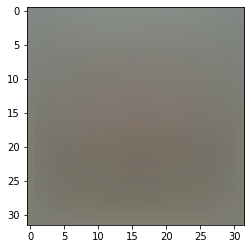

(50000, 3073) (10000, 3073)


In [6]:
# Нормализуем значения яркости пикселей 
mean_image = np.mean(X_train, axis=0)
print(mean_image[:10]) 

# визуализируем среднюю яркость
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((32,32,3)).astype('uint8')) 
plt.show()

# Вычтем средние значения яркости
X_train -= mean_image
X_test -= mean_image

# Добавим к вектору исходных данных фиктивный признак с постоянным значением 1.
# Этот трюк позволит избежать лишних вычислений: x @ W + b  => x' @ W'
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])

print(X_train.shape, X_test.shape)

## Softmax Classifier


In [7]:
p = np.arange(40).reshape(4, 10)
y = np.arange(4)

print('p = \n', p)
print('y = \n', y)

p = 
 [[ 0  1  2  3  4  5  6  7  8  9]
 [10 11 12 13 14 15 16 17 18 19]
 [20 21 22 23 24 25 26 27 28 29]
 [30 31 32 33 34 35 36 37 38 39]]
y = 
 [0 1 2 3]


In [8]:
p[range(4), y]

array([ 0, 11, 22, 33])

In [ ]:
# Реализуйте эффективную векторизованную функцию вычисления CELoss и dW

def softmax_loss(W, X, y, reg=1e-5):
    """
    Softmax loss function, vectorized version.
    Inputs and outputs are the same as softmax_loss_naive.
    """
    # Initialize the loss and gradient to zero.
    loss = 0.0
    dW = np.zeros_like(W)

    #############################################################################
    # TODO: Compute the softmax loss and its gradient using no explicit loops.  #
    # Store the loss in loss and the gradient in dW. If you are not careful     #
    # here, it is easy to run into numeric instability. Don't forget the        #
    # regularization!                                                           #
    #############################################################################
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    N, C = X.shape
    Z = X @ W
    exps = np.exp(Z)
    S = exps / np.sum(exps, axis=0)
    logs = np.log(S[range(N), y])

    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    # print(loss)
    return loss, dL_dW

In [ ]:
# Инициализируем веса значениями близкими, но не равными нулю
W = np.random.randn(3073, 10) * 1e-5
loss, grad = softmax_loss(W, X_test, y_test, 0.0)

# Проверим правильность реализации
# Для 10 классов loss должен быть около -log(0.1).
print('loss: %f' % loss)
print('Начальное значение Loss = %f' % (-np.log(0.1)))

In [ ]:
# Проверим градиент с помощью метода конечных разностей
check_gradient(softmax_loss, X_test[:1], y_test[:1], W)

**Вопрос 1**  Почему значения, вычисленные аналитическим и численным методом, отличаются после 7 знака? Какое значение более правильное, по Вашему мнению?

# Стохастический градиентный спуск

$$\large \frac{dL}{dz} = [ \begin{array}{cc} 
\frac{dL}{dz_1}\\
\frac{dL}{dz_2}
\end{array}  ] $$

$$\large \frac{dL}{dx} =  \begin{array}{cc} 
\frac{dL}{dx_1}\\
\frac{dL}{dx_2} \\
\frac{dL}{dx_3} 
\end{array}   $$

$$\large X @ W =  \begin{array}{cc} 
w_{0,0} \cdot x_0 + w_{0,1} \cdot x_1 + w_{0,2} \cdot x_2 \\
w_{1,0} \cdot x_0 + w_{1,1} \cdot x_1 + w_{1,2} \cdot x_2 \\
\end{array} = 
\begin{array}{cc} 
z_0 \\
z_1
\end{array} 
$$

$$\large \frac{dz}{dx} =  \begin{array}{cc} 
\frac{dz_0}{dx_0}, \frac{dz_0}{dx_1}, \frac{dz_0}{dx_2} \\
\frac{dz_1}{dx_0}, \frac{dz_1}{dx_1}, \frac{dz_1}{dx_2}
\end{array}  = W $$

$$\large \frac{dL}{dW} = [ \begin{array}{cc} 
\frac{dL}{dW_{0,0} }, \frac{dL}{dW_{0,1}}, \frac{dL}{dW_{0,2}} \\
\frac{dL}{dW_{1,0} }, \frac{dL}{dW_{1,1}}, \frac{dL}{dW_{1,2}}
\end{array}  ] $$

In [ ]:
# Реализуйте методы predict и train с оптимизацией SGD  

class Softmax():
    def __init__(self):
        self.W = None

    def train(self, X, y, learning_rate, reg, num_iters=1000,
              batch_size=64, verbose=True):
        """
        Обучение классификатора с помощью стохастического градиентного спуска
        Inputs:
        - X: A numpy array of shape (N, D) containing training data; there are N
          training samples each of dimension D.
        - y: A numpy array of shape (N,) containing training labels; y[i] = c
          means that X[i] has label 0 <= c < C for C classes.
        - learning_rate: (float) learning rate for optimization.
        - reg: (float) regularization strength.
        - num_iters: (integer) number of steps to take when optimizing
        - batch_size: (integer) number of training examples to use at each step.
        - verbose: (boolean) If true, print progress during optimization.
        Outputs:
        A list containing the value of the loss function at each training iteration.
        """
        num_train, dim = X.shape
        num_classes = np.max(y) + 1 # assume y takes values 0...K-1 where K is number of classes
        if self.W is None:
            # lazily initialize W
            self.W = 0.001 * np.random.randn(dim, num_classes)

        # Run stochastic gradient descent to optimize W
        loss_history = []
        for it in range(num_iters):
            X_batch = None
            y_batch = None

            #########################################################################
            # TODO:                                                                 #
            # Sample batch_size elements from the training data and their           #
            # corresponding labels to use in this round of gradient descent.        #
            # Store the data in X_batch and their corresponding labels in           #
            # y_batch; after sampling X_batch should have shape (batch_size, dim)   #
            # and y_batch should have shape (batch_size,)                           #
            #                                                                       #
            # Hint: Use np.random.choice to generate indices. Sampling with         #
            # replacement is faster than sampling without replacement.              #
            #########################################################################
            # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****


            # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

            # evaluate loss and gradient
            loss, grad = self.loss(X_batch, y_batch, reg)
            loss_history.append(loss)

            # perform parameter update
            #########################################################################
            # TODO:                                                                 #
            # Update the weights using the gradient and the learning rate.          #
            #########################################################################
            # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

            self.W -= grad*learning_rate

            # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

            if verbose and it % 100 == 0:
                print('iteration %d / %d: loss %f '  % (it, num_iters, loss))

        return loss_history

    def predict(self, X):
        """
        Use the trained weights of this linear classifier to predict labels for
        data points.
        Inputs:
        - X: A numpy array of shape (N, D) containing training data; there are N
          training samples each of dimension D.
        Returns:
        - y_pred: Predicted labels for the data in X. y_pred is a 1-dimensional
          array of length N, and each element is an integer giving the predicted
          class.
        """
        y_pred = np.zeros(X.shape[0])
        ###########################################################################
        # TODO:                                                                   #
        # Implement this method. Store the predicted labels in y_pred.            #
        ###########################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****


        
        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        return y_pred

    def loss(self, X_batch, y_batch, reg):
        """
        Compute the loss function and its derivative.
        Subclasses will override this.
        Inputs:
        - X_batch: A numpy array of shape (N, D) containing a minibatch of N
          data points; each point has dimension D.
        - y_batch: A numpy array of shape (N,) containing labels for the minibatch.
        - reg: (float) regularization strength.
        Returns: A tuple containing:
        - loss as a single float
        - gradient with respect to self.W; an array of the same shape as W
        """
        return softmax_loss(self.W, X_batch, y_batch, reg)

In [ ]:
softmax_cls = Softmax()
tic = time.time()
loss_hist = softmax_cls.train(X_test, y_test, learning_rate=1e-5, reg=1e-5,
                      num_iters=10000, verbose=True)
toc = time.time()
print('That took %fs' % (toc - tic))

In [ ]:
# Построим график зависимости loss от количества итераций
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [ ]:
# оцените точность предсказания на выборках train и val
y_train_pred = softmax_cls.predict(X_train)
print('training accuracy: %f' % (np.mean(y_train == y_train_pred), ))
y_test_pred = softmax_cls.predict(X_test)
print('test accuracy: %f' % (np.mean(y_test == y_test_pred), ))

# Поиск лучших гиперпараметров

In [ ]:
# Используйте валидационную выборку для выбора лучших гиперпараметров 
# (learning rate and regularization strength)
# Добейтесь точности не меньше 0.35 на выборке test.
# Используйте словарь results в котором 
# ключи - кортеж  (learning_rate, regularization_strength)
# значения - (train_accuracy, test_accuracy)
# Точность вычисляется как отношение числа верно предсказанных классов 
# к объему выборки
results = {}
best_test = -1   
best_cls = None # Лучший экземпляр Softmax classifier 

################################################################################
# TODO:                                                                        #
# Напишите код, позволяющий найти лучшее значение гиперпараметров на test      #
# выборке. Для каждой комбинации гиперпараметров обучите классификатор         #
# на train выборке, вычислите точность на выборках train, test и сохраните     #
# результат в словарь results. Лучшее значение точности сохраните в best_test  #
# лучший классификатор - в best_svm                                            #
################################################################################

# Пример допустимых значений. Можете изменить на свое усмотрение.
learning_rates = [1e-6, 1e-5, 1e-4]
regularization_strengths = [10**n for n in range(-8, 1)]

# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****



# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    
# Вывод результатов.
for lr, reg in sorted(results):
    train_accuracy, test_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f test accuracy: %f' % (
                lr, reg, train_accuracy, test_accuracy))


In [ ]:
# Визуализируем результаты 
import math
import pdb

# pdb.set_trace()

x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]

# график accuracy на обучении
marker_size = 100
colors = [results[x][0] for x in results]
plt.subplot(2, 1, 1)
plt.tight_layout(pad=3)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors, cmap=plt.cm.coolwarm)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 training accuracy')

# график accuracy на test выборке
colors = [results[x][1] for x in results] # default size of markers is 20
plt.subplot(2, 1, 2)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors, cmap=plt.cm.coolwarm)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 test accuracy')
plt.show()

# Точность на test выборке


In [ ]:
y_test_pred = best_cls.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('softmax on raw pixels final test set accuracy: %f' % (test_accuracy, ))

In [ ]:
best_cls.train(X_train, y_train, learning_rate=1e-7, reg=1e-7,
                          num_iters=100000, verbose=True)

In [ ]:
# Визуализируем веса W для каждого класса
plt.rcParams['image.interpolation'] = 'quadric'
w = best_cls.W[:-1,:] # отбросим фиктивное измерение bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)
print(w_min, w_max)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
    
    # Масштабируем веса в значения от 0 до 255 для визуализации
    wimg = 255.0 * (w[:, :, :, i] - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])